In [2]:
import os
import sys
sys.path.insert(0, "../../")

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

import pandas as pd
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

from lips.config import ConfigManager
from lips.utils import get_path

# 1. l2rpn_case14_sandbox grid

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## 1.1 Benchmark1: Risk assessment through contingency screening

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark1", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
kwargs_tau

[(4, (2, 1, 2, 1, 2)), (1, (1, 2, 1, 2, 2, 2)), (5, (1, 1, 2, 2, 1, 2, 2))]

## LeapNet

In this benchmark, we add the topo_vect as input and we inject only the line_status in tau. To do this, go to the benchmark config file, add topo_vect in the input attributes and don't forget to remove it from the tau attributes

In [5]:
leap_net1 = LeapNet(name="tf_leapnet",
                                      
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,

                   loss = {"name": "mse"},
                   lr = 1e-4,
                   activation = tf.keras.layers.LeakyReLU(alpha=0.01),
                    
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   layer = "resnet",
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   scaler = PowerGridScaler,
                   )


In [6]:
import time
start_time = time.time()

In [7]:
leap_net1.train(train_dataset=benchmark1.train_dataset,
                val_dataset=benchmark1.val_dataset,
                batch_size = 128,
                epochs=800)

2022-07-22 14:05:54.633370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:05:55.047754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:83:00.0, compute capability: 8.6


Epoch 1/800
  33/1172 [..............................] - ETA: 5s - loss: 12.2740 - a_or_hat_loss: 5.8163 - a_ex_hat_loss: 6.4577 - a_or_hat_mae: 1.9541 - a_ex_hat_mae: 2.0939

2022-07-22 14:08:10.968229: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 7s 5ms/step - loss: 0.7860 - a_or_hat_loss: 0.3796 - a_ex_hat_loss: 0.4064 - a_or_hat_mae: 0.3273 - a_ex_hat_mae: 0.3345 - val_loss: 0.1677 - val_a_or_hat_loss: 0.0839 - val_a_ex_hat_loss: 0.0838 - val_a_or_hat_mae: 0.1905 - val_a_ex_hat_mae: 0.1890
Epoch 2/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0634 - a_or_hat_loss: 0.0324 - a_ex_hat_loss: 0.0310 - a_or_hat_mae: 0.1163 - a_ex_hat_mae: 0.1134 - val_loss: 0.0425 - val_a_or_hat_loss: 0.0221 - val_a_ex_hat_loss: 0.0204 - val_a_or_hat_mae: 0.1035 - val_a_ex_hat_mae: 0.0987
Epoch 3/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0252 - a_or_hat_loss: 0.0131 - a_ex_hat_loss: 0.0121 - a_or_hat_mae: 0.0769 - a_ex_hat_mae: 0.0740 - val_loss: 0.0247 - val_a_or_hat_loss: 0.0130 - val_a_ex_hat_loss: 0.0117 - val_a_or_hat_mae: 0.0804 - val_a_ex_hat_mae: 0.0765
Epoch 4/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0158 - a_or_

Epoch 28/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0026 - a_or_hat_loss: 0.0013 - a_ex_hat_loss: 0.0012 - a_or_hat_mae: 0.0251 - a_ex_hat_mae: 0.0240 - val_loss: 0.0041 - val_a_or_hat_loss: 0.0021 - val_a_ex_hat_loss: 0.0020 - val_a_or_hat_mae: 0.0337 - val_a_ex_hat_mae: 0.0322
Epoch 29/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0025 - a_or_hat_loss: 0.0013 - a_ex_hat_loss: 0.0012 - a_or_hat_mae: 0.0250 - a_ex_hat_mae: 0.0239 - val_loss: 0.0029 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0272 - val_a_ex_hat_mae: 0.0256
Epoch 30/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0024 - a_or_hat_loss: 0.0013 - a_ex_hat_loss: 0.0012 - a_or_hat_mae: 0.0245 - a_ex_hat_mae: 0.0234 - val_loss: 0.0029 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0268 - val_a_ex_hat_mae: 0.0257
Epoch 31/800
1172/1172 [==============================] - 6s 5ms/step - loss

1172/1172 [==============================] - 6s 5ms/step - loss: 0.0013 - a_or_hat_loss: 6.5487e-04 - a_ex_hat_loss: 6.3538e-04 - a_or_hat_mae: 0.0179 - a_ex_hat_mae: 0.0174 - val_loss: 0.0020 - val_a_or_hat_loss: 9.9976e-04 - val_a_ex_hat_loss: 9.8523e-04 - val_a_or_hat_mae: 0.0233 - val_a_ex_hat_mae: 0.0231
Epoch 80/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0013 - a_or_hat_loss: 6.5288e-04 - a_ex_hat_loss: 6.3248e-04 - a_or_hat_mae: 0.0178 - a_ex_hat_mae: 0.0173 - val_loss: 0.0015 - val_a_or_hat_loss: 7.7862e-04 - val_a_ex_hat_loss: 7.4001e-04 - val_a_or_hat_mae: 0.0196 - val_a_ex_hat_mae: 0.0190
Epoch 81/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0013 - a_or_hat_loss: 6.5887e-04 - a_ex_hat_loss: 6.3861e-04 - a_or_hat_mae: 0.0180 - a_ex_hat_mae: 0.0175 - val_loss: 0.0015 - val_a_or_hat_loss: 7.5705e-04 - val_a_ex_hat_loss: 7.3656e-04 - val_a_or_hat_mae: 0.0194 - val_a_ex_hat_mae: 0.0189
Epoch 82/800
1172/1172 [=================

1172/1172 [==============================] - 6s 5ms/step - loss: 9.6889e-04 - a_or_hat_loss: 4.9263e-04 - a_ex_hat_loss: 4.7626e-04 - a_or_hat_mae: 0.0156 - a_ex_hat_mae: 0.0151 - val_loss: 0.0013 - val_a_or_hat_loss: 6.7624e-04 - val_a_ex_hat_loss: 6.0477e-04 - val_a_or_hat_mae: 0.0188 - val_a_ex_hat_mae: 0.0172
Epoch 130/800
1172/1172 [==============================] - 6s 5ms/step - loss: 9.6369e-04 - a_or_hat_loss: 4.8886e-04 - a_ex_hat_loss: 4.7484e-04 - a_or_hat_mae: 0.0155 - a_ex_hat_mae: 0.0151 - val_loss: 0.0013 - val_a_or_hat_loss: 6.3044e-04 - val_a_ex_hat_loss: 6.3087e-04 - val_a_or_hat_mae: 0.0179 - val_a_ex_hat_mae: 0.0180
Epoch 131/800
1172/1172 [==============================] - 6s 5ms/step - loss: 9.5838e-04 - a_or_hat_loss: 4.8485e-04 - a_ex_hat_loss: 4.7353e-04 - a_or_hat_mae: 0.0154 - a_ex_hat_mae: 0.0150 - val_loss: 0.0011 - val_a_or_hat_loss: 5.9960e-04 - val_a_ex_hat_loss: 5.3546e-04 - val_a_or_hat_mae: 0.0176 - val_a_ex_hat_mae: 0.0162
Epoch 132/800
1172/1172 [==

Epoch 154/800
1172/1172 [==============================] - 6s 5ms/step - loss: 8.6016e-04 - a_or_hat_loss: 4.3536e-04 - a_ex_hat_loss: 4.2481e-04 - a_or_hat_mae: 0.0146 - a_ex_hat_mae: 0.0142 - val_loss: 0.0012 - val_a_or_hat_loss: 6.5419e-04 - val_a_ex_hat_loss: 5.5404e-04 - val_a_or_hat_mae: 0.0185 - val_a_ex_hat_mae: 0.0164
Epoch 155/800
1172/1172 [==============================] - 6s 5ms/step - loss: 8.6648e-04 - a_or_hat_loss: 4.3832e-04 - a_ex_hat_loss: 4.2816e-04 - a_or_hat_mae: 0.0147 - a_ex_hat_mae: 0.0143 - val_loss: 0.0010 - val_a_or_hat_loss: 5.1614e-04 - val_a_ex_hat_loss: 5.2069e-04 - val_a_or_hat_mae: 0.0160 - val_a_ex_hat_mae: 0.0162
Epoch 156/800
1172/1172 [==============================] - 6s 5ms/step - loss: 8.5439e-04 - a_or_hat_loss: 4.3176e-04 - a_ex_hat_loss: 4.2263e-04 - a_or_hat_mae: 0.0145 - a_ex_hat_mae: 0.0142 - val_loss: 0.0012 - val_a_or_hat_loss: 5.8907e-04 - val_a_ex_hat_loss: 5.8029e-04 - val_a_or_hat_mae: 0.0168 - val_a_ex_hat_mae: 0.0166
Epoch 157/800

Epoch 179/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.7885e-04 - a_or_hat_loss: 3.9367e-04 - a_ex_hat_loss: 3.8518e-04 - a_or_hat_mae: 0.0139 - a_ex_hat_mae: 0.0136 - val_loss: 0.0017 - val_a_or_hat_loss: 8.7241e-04 - val_a_ex_hat_loss: 7.9894e-04 - val_a_or_hat_mae: 0.0214 - val_a_ex_hat_mae: 0.0203
Epoch 180/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.8120e-04 - a_or_hat_loss: 3.9624e-04 - a_ex_hat_loss: 3.8495e-04 - a_or_hat_mae: 0.0139 - a_ex_hat_mae: 0.0135 - val_loss: 8.6150e-04 - val_a_or_hat_loss: 4.3713e-04 - val_a_ex_hat_loss: 4.2437e-04 - val_a_or_hat_mae: 0.0148 - val_a_ex_hat_mae: 0.0144
Epoch 181/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.7652e-04 - a_or_hat_loss: 3.9375e-04 - a_ex_hat_loss: 3.8277e-04 - a_or_hat_mae: 0.0139 - a_ex_hat_mae: 0.0135 - val_loss: 0.0010 - val_a_or_hat_loss: 5.1880e-04 - val_a_ex_hat_loss: 4.8827e-04 - val_a_or_hat_mae: 0.0164 - val_a_ex_hat_mae: 0.0155
Epoch 182

Epoch 204/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.1783e-04 - a_or_hat_loss: 3.6402e-04 - a_ex_hat_loss: 3.5381e-04 - a_or_hat_mae: 0.0133 - a_ex_hat_mae: 0.0130 - val_loss: 8.8207e-04 - val_a_or_hat_loss: 4.5440e-04 - val_a_ex_hat_loss: 4.2767e-04 - val_a_or_hat_mae: 0.0152 - val_a_ex_hat_mae: 0.0145
Epoch 205/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.0295e-04 - a_or_hat_loss: 3.5732e-04 - a_ex_hat_loss: 3.4563e-04 - a_or_hat_mae: 0.0133 - a_ex_hat_mae: 0.0129 - val_loss: 8.2251e-04 - val_a_or_hat_loss: 4.1490e-04 - val_a_ex_hat_loss: 4.0761e-04 - val_a_or_hat_mae: 0.0142 - val_a_ex_hat_mae: 0.0141
Epoch 206/800
1172/1172 [==============================] - 6s 5ms/step - loss: 7.1242e-04 - a_or_hat_loss: 3.6229e-04 - a_ex_hat_loss: 3.5012e-04 - a_or_hat_mae: 0.0133 - a_ex_hat_mae: 0.0129 - val_loss: 9.3936e-04 - val_a_or_hat_loss: 4.4829e-04 - val_a_ex_hat_loss: 4.9106e-04 - val_a_or_hat_mae: 0.0148 - val_a_ex_hat_mae: 0.0151
E

Epoch 229/800
1172/1172 [==============================] - 6s 5ms/step - loss: 6.3267e-04 - a_or_hat_loss: 3.2301e-04 - a_ex_hat_loss: 3.0966e-04 - a_or_hat_mae: 0.0126 - a_ex_hat_mae: 0.0122 - val_loss: 9.3079e-04 - val_a_or_hat_loss: 4.8080e-04 - val_a_ex_hat_loss: 4.4998e-04 - val_a_or_hat_mae: 0.0155 - val_a_ex_hat_mae: 0.0151
Epoch 230/800
1172/1172 [==============================] - 6s 5ms/step - loss: 6.4950e-04 - a_or_hat_loss: 3.3206e-04 - a_ex_hat_loss: 3.1743e-04 - a_or_hat_mae: 0.0128 - a_ex_hat_mae: 0.0124 - val_loss: 8.1520e-04 - val_a_or_hat_loss: 4.1630e-04 - val_a_ex_hat_loss: 3.9890e-04 - val_a_or_hat_mae: 0.0143 - val_a_ex_hat_mae: 0.0142
Epoch 231/800
1172/1172 [==============================] - 6s 5ms/step - loss: 6.6208e-04 - a_or_hat_loss: 3.3697e-04 - a_ex_hat_loss: 3.2511e-04 - a_or_hat_mae: 0.0129 - a_ex_hat_mae: 0.0125 - val_loss: 7.9026e-04 - val_a_or_hat_loss: 3.9676e-04 - val_a_ex_hat_loss: 3.9350e-04 - val_a_or_hat_mae: 0.0139 - val_a_ex_hat_mae: 0.0139
E

Epoch 254/800
1172/1172 [==============================] - 6s 5ms/step - loss: 6.0818e-04 - a_or_hat_loss: 3.1145e-04 - a_ex_hat_loss: 2.9673e-04 - a_or_hat_mae: 0.0124 - a_ex_hat_mae: 0.0120 - val_loss: 8.1368e-04 - val_a_or_hat_loss: 4.2243e-04 - val_a_ex_hat_loss: 3.9125e-04 - val_a_or_hat_mae: 0.0145 - val_a_ex_hat_mae: 0.0139
Epoch 255/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.9863e-04 - a_or_hat_loss: 3.0656e-04 - a_ex_hat_loss: 2.9206e-04 - a_or_hat_mae: 0.0122 - a_ex_hat_mae: 0.0118 - val_loss: 7.8536e-04 - val_a_or_hat_loss: 4.0716e-04 - val_a_ex_hat_loss: 3.7820e-04 - val_a_or_hat_mae: 0.0143 - val_a_ex_hat_mae: 0.0138
Epoch 256/800
1172/1172 [==============================] - 6s 5ms/step - loss: 6.0111e-04 - a_or_hat_loss: 3.0818e-04 - a_ex_hat_loss: 2.9294e-04 - a_or_hat_mae: 0.0123 - a_ex_hat_mae: 0.0119 - val_loss: 7.3849e-04 - val_a_or_hat_loss: 3.8288e-04 - val_a_ex_hat_loss: 3.5562e-04 - val_a_or_hat_mae: 0.0137 - val_a_ex_hat_mae: 0.0132
E

Epoch 279/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.6675e-04 - a_or_hat_loss: 2.8993e-04 - a_ex_hat_loss: 2.7682e-04 - a_or_hat_mae: 0.0119 - a_ex_hat_mae: 0.0115 - val_loss: 7.0054e-04 - val_a_or_hat_loss: 3.6401e-04 - val_a_ex_hat_loss: 3.3653e-04 - val_a_or_hat_mae: 0.0134 - val_a_ex_hat_mae: 0.0127
Epoch 280/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.6859e-04 - a_or_hat_loss: 2.9155e-04 - a_ex_hat_loss: 2.7703e-04 - a_or_hat_mae: 0.0119 - a_ex_hat_mae: 0.0115 - val_loss: 7.5527e-04 - val_a_or_hat_loss: 3.8157e-04 - val_a_ex_hat_loss: 3.7370e-04 - val_a_or_hat_mae: 0.0136 - val_a_ex_hat_mae: 0.0134
Epoch 281/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.5459e-04 - a_or_hat_loss: 2.8440e-04 - a_ex_hat_loss: 2.7018e-04 - a_or_hat_mae: 0.0118 - a_ex_hat_mae: 0.0114 - val_loss: 7.5521e-04 - val_a_or_hat_loss: 3.8272e-04 - val_a_ex_hat_loss: 3.7249e-04 - val_a_or_hat_mae: 0.0140 - val_a_ex_hat_mae: 0.0139
E

Epoch 304/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.3290e-04 - a_or_hat_loss: 2.7253e-04 - a_ex_hat_loss: 2.6037e-04 - a_or_hat_mae: 0.0115 - a_ex_hat_mae: 0.0112 - val_loss: 6.5899e-04 - val_a_or_hat_loss: 3.3251e-04 - val_a_ex_hat_loss: 3.2648e-04 - val_a_or_hat_mae: 0.0128 - val_a_ex_hat_mae: 0.0128
Epoch 305/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.2193e-04 - a_or_hat_loss: 2.6758e-04 - a_ex_hat_loss: 2.5434e-04 - a_or_hat_mae: 0.0114 - a_ex_hat_mae: 0.0110 - val_loss: 6.7995e-04 - val_a_or_hat_loss: 3.4347e-04 - val_a_ex_hat_loss: 3.3648e-04 - val_a_or_hat_mae: 0.0130 - val_a_ex_hat_mae: 0.0128
Epoch 306/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.3948e-04 - a_or_hat_loss: 2.7642e-04 - a_ex_hat_loss: 2.6306e-04 - a_or_hat_mae: 0.0116 - a_ex_hat_mae: 0.0113 - val_loss: 6.3910e-04 - val_a_or_hat_loss: 3.2012e-04 - val_a_ex_hat_loss: 3.1898e-04 - val_a_or_hat_mae: 0.0126 - val_a_ex_hat_mae: 0.0125
E

Epoch 329/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.0815e-04 - a_or_hat_loss: 2.5952e-04 - a_ex_hat_loss: 2.4863e-04 - a_or_hat_mae: 0.0113 - a_ex_hat_mae: 0.0109 - val_loss: 6.5608e-04 - val_a_or_hat_loss: 3.3424e-04 - val_a_ex_hat_loss: 3.2184e-04 - val_a_or_hat_mae: 0.0129 - val_a_ex_hat_mae: 0.0127
Epoch 330/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.0777e-04 - a_or_hat_loss: 2.5964e-04 - a_ex_hat_loss: 2.4813e-04 - a_or_hat_mae: 0.0112 - a_ex_hat_mae: 0.0109 - val_loss: 8.0467e-04 - val_a_or_hat_loss: 4.1450e-04 - val_a_ex_hat_loss: 3.9016e-04 - val_a_or_hat_mae: 0.0145 - val_a_ex_hat_mae: 0.0139
Epoch 331/800
1172/1172 [==============================] - 6s 5ms/step - loss: 5.0457e-04 - a_or_hat_loss: 2.5795e-04 - a_ex_hat_loss: 2.4662e-04 - a_or_hat_mae: 0.0112 - a_ex_hat_mae: 0.0109 - val_loss: 6.6315e-04 - val_a_or_hat_loss: 3.4631e-04 - val_a_ex_hat_loss: 3.1684e-04 - val_a_or_hat_mae: 0.0130 - val_a_ex_hat_mae: 0.0124
E

Epoch 354/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.8840e-04 - a_or_hat_loss: 2.4974e-04 - a_ex_hat_loss: 2.3866e-04 - a_or_hat_mae: 0.0111 - a_ex_hat_mae: 0.0107 - val_loss: 5.5532e-04 - val_a_or_hat_loss: 2.8463e-04 - val_a_ex_hat_loss: 2.7068e-04 - val_a_or_hat_mae: 0.0117 - val_a_ex_hat_mae: 0.0114
Epoch 355/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.8103e-04 - a_or_hat_loss: 2.4666e-04 - a_ex_hat_loss: 2.3437e-04 - a_or_hat_mae: 0.0110 - a_ex_hat_mae: 0.0106 - val_loss: 6.0055e-04 - val_a_or_hat_loss: 3.0832e-04 - val_a_ex_hat_loss: 2.9223e-04 - val_a_or_hat_mae: 0.0123 - val_a_ex_hat_mae: 0.0118
Epoch 356/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.7640e-04 - a_or_hat_loss: 2.4383e-04 - a_ex_hat_loss: 2.3257e-04 - a_or_hat_mae: 0.0109 - a_ex_hat_mae: 0.0105 - val_loss: 6.5662e-04 - val_a_or_hat_loss: 3.2842e-04 - val_a_ex_hat_loss: 3.2819e-04 - val_a_or_hat_mae: 0.0130 - val_a_ex_hat_mae: 0.0130
E

Epoch 379/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.6030e-04 - a_or_hat_loss: 2.3513e-04 - a_ex_hat_loss: 2.2517e-04 - a_or_hat_mae: 0.0107 - a_ex_hat_mae: 0.0104 - val_loss: 5.8693e-04 - val_a_or_hat_loss: 2.9206e-04 - val_a_ex_hat_loss: 2.9487e-04 - val_a_or_hat_mae: 0.0118 - val_a_ex_hat_mae: 0.0121
Epoch 380/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.5785e-04 - a_or_hat_loss: 2.3438e-04 - a_ex_hat_loss: 2.2347e-04 - a_or_hat_mae: 0.0107 - a_ex_hat_mae: 0.0103 - val_loss: 5.8055e-04 - val_a_or_hat_loss: 2.9463e-04 - val_a_ex_hat_loss: 2.8592e-04 - val_a_or_hat_mae: 0.0119 - val_a_ex_hat_mae: 0.0120
Epoch 381/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.6774e-04 - a_or_hat_loss: 2.3952e-04 - a_ex_hat_loss: 2.2821e-04 - a_or_hat_mae: 0.0108 - a_ex_hat_mae: 0.0105 - val_loss: 6.5120e-04 - val_a_or_hat_loss: 3.3631e-04 - val_a_ex_hat_loss: 3.1489e-04 - val_a_or_hat_mae: 0.0131 - val_a_ex_hat_mae: 0.0127
E

Epoch 404/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.3830e-04 - a_or_hat_loss: 2.2468e-04 - a_ex_hat_loss: 2.1362e-04 - a_or_hat_mae: 0.0104 - a_ex_hat_mae: 0.0101 - val_loss: 5.7062e-04 - val_a_or_hat_loss: 2.8453e-04 - val_a_ex_hat_loss: 2.8609e-04 - val_a_or_hat_mae: 0.0119 - val_a_ex_hat_mae: 0.0118
Epoch 405/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.3545e-04 - a_or_hat_loss: 2.2253e-04 - a_ex_hat_loss: 2.1292e-04 - a_or_hat_mae: 0.0104 - a_ex_hat_mae: 0.0101 - val_loss: 6.2918e-04 - val_a_or_hat_loss: 3.2070e-04 - val_a_ex_hat_loss: 3.0848e-04 - val_a_or_hat_mae: 0.0127 - val_a_ex_hat_mae: 0.0124
Epoch 406/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.4920e-04 - a_or_hat_loss: 2.3028e-04 - a_ex_hat_loss: 2.1892e-04 - a_or_hat_mae: 0.0106 - a_ex_hat_mae: 0.0102 - val_loss: 5.5819e-04 - val_a_or_hat_loss: 2.8771e-04 - val_a_ex_hat_loss: 2.7048e-04 - val_a_or_hat_mae: 0.0119 - val_a_ex_hat_mae: 0.0115
E

Epoch 429/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.1809e-04 - a_or_hat_loss: 2.1332e-04 - a_ex_hat_loss: 2.0477e-04 - a_or_hat_mae: 0.0102 - a_ex_hat_mae: 0.0099 - val_loss: 6.1310e-04 - val_a_or_hat_loss: 3.1664e-04 - val_a_ex_hat_loss: 2.9646e-04 - val_a_or_hat_mae: 0.0125 - val_a_ex_hat_mae: 0.0122
Epoch 430/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.2774e-04 - a_or_hat_loss: 2.1842e-04 - a_ex_hat_loss: 2.0932e-04 - a_or_hat_mae: 0.0103 - a_ex_hat_mae: 0.0100 - val_loss: 5.2147e-04 - val_a_or_hat_loss: 2.6832e-04 - val_a_ex_hat_loss: 2.5316e-04 - val_a_or_hat_mae: 0.0115 - val_a_ex_hat_mae: 0.0111
Epoch 431/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.1844e-04 - a_or_hat_loss: 2.1366e-04 - a_ex_hat_loss: 2.0478e-04 - a_or_hat_mae: 0.0102 - a_ex_hat_mae: 0.0099 - val_loss: 5.2054e-04 - val_a_or_hat_loss: 2.6616e-04 - val_a_ex_hat_loss: 2.5439e-04 - val_a_or_hat_mae: 0.0114 - val_a_ex_hat_mae: 0.0112
E

Epoch 454/800
1172/1172 [==============================] - 6s 5ms/step - loss: 4.0610e-04 - a_or_hat_loss: 2.0714e-04 - a_ex_hat_loss: 1.9896e-04 - a_or_hat_mae: 0.0100 - a_ex_hat_mae: 0.0097 - val_loss: 5.2802e-04 - val_a_or_hat_loss: 2.7000e-04 - val_a_ex_hat_loss: 2.5803e-04 - val_a_or_hat_mae: 0.0116 - val_a_ex_hat_mae: 0.0112
Epoch 455/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.9702e-04 - a_or_hat_loss: 2.0280e-04 - a_ex_hat_loss: 1.9422e-04 - a_or_hat_mae: 0.0099 - a_ex_hat_mae: 0.0096 - val_loss: 5.1786e-04 - val_a_or_hat_loss: 2.6982e-04 - val_a_ex_hat_loss: 2.4804e-04 - val_a_or_hat_mae: 0.0114 - val_a_ex_hat_mae: 0.0110
Epoch 456/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.9506e-04 - a_or_hat_loss: 2.0218e-04 - a_ex_hat_loss: 1.9288e-04 - a_or_hat_mae: 0.0099 - a_ex_hat_mae: 0.0096 - val_loss: 5.0508e-04 - val_a_or_hat_loss: 2.6280e-04 - val_a_ex_hat_loss: 2.4228e-04 - val_a_or_hat_mae: 0.0114 - val_a_ex_hat_mae: 0.0108
E

Epoch 479/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.8754e-04 - a_or_hat_loss: 1.9801e-04 - a_ex_hat_loss: 1.8953e-04 - a_or_hat_mae: 0.0098 - a_ex_hat_mae: 0.0095 - val_loss: 6.0367e-04 - val_a_or_hat_loss: 3.0583e-04 - val_a_ex_hat_loss: 2.9784e-04 - val_a_or_hat_mae: 0.0123 - val_a_ex_hat_mae: 0.0121
Epoch 480/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.8008e-04 - a_or_hat_loss: 1.9379e-04 - a_ex_hat_loss: 1.8629e-04 - a_or_hat_mae: 0.0097 - a_ex_hat_mae: 0.0094 - val_loss: 4.7467e-04 - val_a_or_hat_loss: 2.3962e-04 - val_a_ex_hat_loss: 2.3506e-04 - val_a_or_hat_mae: 0.0107 - val_a_ex_hat_mae: 0.0106
Epoch 481/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.9064e-04 - a_or_hat_loss: 1.9862e-04 - a_ex_hat_loss: 1.9203e-04 - a_or_hat_mae: 0.0098 - a_ex_hat_mae: 0.0096 - val_loss: 4.9524e-04 - val_a_or_hat_loss: 2.5561e-04 - val_a_ex_hat_loss: 2.3964e-04 - val_a_or_hat_mae: 0.0113 - val_a_ex_hat_mae: 0.0109
E

Epoch 504/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.7874e-04 - a_or_hat_loss: 1.9212e-04 - a_ex_hat_loss: 1.8662e-04 - a_or_hat_mae: 0.0097 - a_ex_hat_mae: 0.0094 - val_loss: 6.7040e-04 - val_a_or_hat_loss: 3.3630e-04 - val_a_ex_hat_loss: 3.3410e-04 - val_a_or_hat_mae: 0.0127 - val_a_ex_hat_mae: 0.0123
Epoch 505/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.7121e-04 - a_or_hat_loss: 1.8877e-04 - a_ex_hat_loss: 1.8244e-04 - a_or_hat_mae: 0.0096 - a_ex_hat_mae: 0.0093 - val_loss: 4.5237e-04 - val_a_or_hat_loss: 2.2815e-04 - val_a_ex_hat_loss: 2.2421e-04 - val_a_or_hat_mae: 0.0106 - val_a_ex_hat_mae: 0.0105
Epoch 506/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.7989e-04 - a_or_hat_loss: 1.9387e-04 - a_ex_hat_loss: 1.8602e-04 - a_or_hat_mae: 0.0097 - a_ex_hat_mae: 0.0094 - val_loss: 4.3576e-04 - val_a_or_hat_loss: 2.2557e-04 - val_a_ex_hat_loss: 2.1019e-04 - val_a_or_hat_mae: 0.0105 - val_a_ex_hat_mae: 0.0100
E

Epoch 529/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.7494e-04 - a_or_hat_loss: 1.9087e-04 - a_ex_hat_loss: 1.8407e-04 - a_or_hat_mae: 0.0096 - a_ex_hat_mae: 0.0093 - val_loss: 5.7694e-04 - val_a_or_hat_loss: 2.9878e-04 - val_a_ex_hat_loss: 2.7816e-04 - val_a_or_hat_mae: 0.0115 - val_a_ex_hat_mae: 0.0110
Epoch 530/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.4738e-04 - a_or_hat_loss: 1.7658e-04 - a_ex_hat_loss: 1.7081e-04 - a_or_hat_mae: 0.0092 - a_ex_hat_mae: 0.0090 - val_loss: 4.5708e-04 - val_a_or_hat_loss: 2.2874e-04 - val_a_ex_hat_loss: 2.2834e-04 - val_a_or_hat_mae: 0.0105 - val_a_ex_hat_mae: 0.0105
Epoch 531/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.5624e-04 - a_or_hat_loss: 1.8098e-04 - a_ex_hat_loss: 1.7526e-04 - a_or_hat_mae: 0.0094 - a_ex_hat_mae: 0.0091 - val_loss: 4.9607e-04 - val_a_or_hat_loss: 2.4471e-04 - val_a_ex_hat_loss: 2.5136e-04 - val_a_or_hat_mae: 0.0109 - val_a_ex_hat_mae: 0.0111
E

Epoch 554/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.6817e-04 - a_or_hat_loss: 1.8735e-04 - a_ex_hat_loss: 1.8083e-04 - a_or_hat_mae: 0.0095 - a_ex_hat_mae: 0.0092 - val_loss: 4.1989e-04 - val_a_or_hat_loss: 2.1066e-04 - val_a_ex_hat_loss: 2.0923e-04 - val_a_or_hat_mae: 0.0099 - val_a_ex_hat_mae: 0.0100
Epoch 555/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.4527e-04 - a_or_hat_loss: 1.7474e-04 - a_ex_hat_loss: 1.7053e-04 - a_or_hat_mae: 0.0092 - a_ex_hat_mae: 0.0090 - val_loss: 4.7785e-04 - val_a_or_hat_loss: 2.4303e-04 - val_a_ex_hat_loss: 2.3483e-04 - val_a_or_hat_mae: 0.0110 - val_a_ex_hat_mae: 0.0108
Epoch 556/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.4254e-04 - a_or_hat_loss: 1.7389e-04 - a_ex_hat_loss: 1.6864e-04 - a_or_hat_mae: 0.0092 - a_ex_hat_mae: 0.0090 - val_loss: 4.5097e-04 - val_a_or_hat_loss: 2.1756e-04 - val_a_ex_hat_loss: 2.3342e-04 - val_a_or_hat_mae: 0.0103 - val_a_ex_hat_mae: 0.0106
E

Epoch 579/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.3843e-04 - a_or_hat_loss: 1.7127e-04 - a_ex_hat_loss: 1.6717e-04 - a_or_hat_mae: 0.0091 - a_ex_hat_mae: 0.0089 - val_loss: 4.7417e-04 - val_a_or_hat_loss: 2.3801e-04 - val_a_ex_hat_loss: 2.3617e-04 - val_a_or_hat_mae: 0.0106 - val_a_ex_hat_mae: 0.0104
Epoch 580/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.4777e-04 - a_or_hat_loss: 1.7572e-04 - a_ex_hat_loss: 1.7205e-04 - a_or_hat_mae: 0.0092 - a_ex_hat_mae: 0.0090 - val_loss: 4.4299e-04 - val_a_or_hat_loss: 2.2311e-04 - val_a_ex_hat_loss: 2.1988e-04 - val_a_or_hat_mae: 0.0104 - val_a_ex_hat_mae: 0.0103
Epoch 581/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.2782e-04 - a_or_hat_loss: 1.6567e-04 - a_ex_hat_loss: 1.6215e-04 - a_or_hat_mae: 0.0090 - a_ex_hat_mae: 0.0088 - val_loss: 4.5458e-04 - val_a_or_hat_loss: 2.2872e-04 - val_a_ex_hat_loss: 2.2586e-04 - val_a_or_hat_mae: 0.0105 - val_a_ex_hat_mae: 0.0104
E

Epoch 604/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.2521e-04 - a_or_hat_loss: 1.6495e-04 - a_ex_hat_loss: 1.6026e-04 - a_or_hat_mae: 0.0089 - a_ex_hat_mae: 0.0087 - val_loss: 4.4107e-04 - val_a_or_hat_loss: 2.2784e-04 - val_a_ex_hat_loss: 2.1323e-04 - val_a_or_hat_mae: 0.0108 - val_a_ex_hat_mae: 0.0100
Epoch 605/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.2919e-04 - a_or_hat_loss: 1.6629e-04 - a_ex_hat_loss: 1.6291e-04 - a_or_hat_mae: 0.0090 - a_ex_hat_mae: 0.0088 - val_loss: 5.1873e-04 - val_a_or_hat_loss: 2.6974e-04 - val_a_ex_hat_loss: 2.4900e-04 - val_a_or_hat_mae: 0.0118 - val_a_ex_hat_mae: 0.0109
Epoch 606/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.2971e-04 - a_or_hat_loss: 1.6674e-04 - a_ex_hat_loss: 1.6297e-04 - a_or_hat_mae: 0.0090 - a_ex_hat_mae: 0.0088 - val_loss: 4.8146e-04 - val_a_or_hat_loss: 2.4638e-04 - val_a_ex_hat_loss: 2.3507e-04 - val_a_or_hat_mae: 0.0110 - val_a_ex_hat_mae: 0.0108
E

Epoch 629/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.1645e-04 - a_or_hat_loss: 1.5962e-04 - a_ex_hat_loss: 1.5683e-04 - a_or_hat_mae: 0.0088 - a_ex_hat_mae: 0.0086 - val_loss: 3.8972e-04 - val_a_or_hat_loss: 1.9648e-04 - val_a_ex_hat_loss: 1.9324e-04 - val_a_or_hat_mae: 0.0097 - val_a_ex_hat_mae: 0.0096
Epoch 630/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.1644e-04 - a_or_hat_loss: 1.5949e-04 - a_ex_hat_loss: 1.5694e-04 - a_or_hat_mae: 0.0088 - a_ex_hat_mae: 0.0086 - val_loss: 4.0150e-04 - val_a_or_hat_loss: 2.0265e-04 - val_a_ex_hat_loss: 1.9886e-04 - val_a_or_hat_mae: 0.0098 - val_a_ex_hat_mae: 0.0097
Epoch 631/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.1240e-04 - a_or_hat_loss: 1.5771e-04 - a_ex_hat_loss: 1.5469e-04 - a_or_hat_mae: 0.0087 - a_ex_hat_mae: 0.0086 - val_loss: 4.3776e-04 - val_a_or_hat_loss: 2.2254e-04 - val_a_ex_hat_loss: 2.1522e-04 - val_a_or_hat_mae: 0.0105 - val_a_ex_hat_mae: 0.0103
E

Epoch 654/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.0897e-04 - a_or_hat_loss: 1.5538e-04 - a_ex_hat_loss: 1.5359e-04 - a_or_hat_mae: 0.0087 - a_ex_hat_mae: 0.0085 - val_loss: 4.1018e-04 - val_a_or_hat_loss: 2.0233e-04 - val_a_ex_hat_loss: 2.0785e-04 - val_a_or_hat_mae: 0.0099 - val_a_ex_hat_mae: 0.0100
Epoch 655/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.1151e-04 - a_or_hat_loss: 1.5697e-04 - a_ex_hat_loss: 1.5454e-04 - a_or_hat_mae: 0.0087 - a_ex_hat_mae: 0.0086 - val_loss: 3.7981e-04 - val_a_or_hat_loss: 1.8552e-04 - val_a_ex_hat_loss: 1.9429e-04 - val_a_or_hat_mae: 0.0094 - val_a_ex_hat_mae: 0.0097
Epoch 656/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.1648e-04 - a_or_hat_loss: 1.5902e-04 - a_ex_hat_loss: 1.5746e-04 - a_or_hat_mae: 0.0088 - a_ex_hat_mae: 0.0086 - val_loss: 3.8967e-04 - val_a_or_hat_loss: 1.9490e-04 - val_a_ex_hat_loss: 1.9477e-04 - val_a_or_hat_mae: 0.0095 - val_a_ex_hat_mae: 0.0096
E

Epoch 679/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.0162e-04 - a_or_hat_loss: 1.5131e-04 - a_ex_hat_loss: 1.5031e-04 - a_or_hat_mae: 0.0085 - a_ex_hat_mae: 0.0084 - val_loss: 4.0316e-04 - val_a_or_hat_loss: 2.0177e-04 - val_a_ex_hat_loss: 2.0139e-04 - val_a_or_hat_mae: 0.0099 - val_a_ex_hat_mae: 0.0099
Epoch 680/800
1172/1172 [==============================] - 6s 5ms/step - loss: 3.0478e-04 - a_or_hat_loss: 1.5296e-04 - a_ex_hat_loss: 1.5182e-04 - a_or_hat_mae: 0.0086 - a_ex_hat_mae: 0.0085 - val_loss: 3.6541e-04 - val_a_or_hat_loss: 1.7666e-04 - val_a_ex_hat_loss: 1.8876e-04 - val_a_or_hat_mae: 0.0093 - val_a_ex_hat_mae: 0.0096
Epoch 681/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.9331e-04 - a_or_hat_loss: 1.4705e-04 - a_ex_hat_loss: 1.4626e-04 - a_or_hat_mae: 0.0084 - a_ex_hat_mae: 0.0083 - val_loss: 3.9662e-04 - val_a_or_hat_loss: 1.9409e-04 - val_a_ex_hat_loss: 2.0253e-04 - val_a_or_hat_mae: 0.0095 - val_a_ex_hat_mae: 0.0097
E

Epoch 704/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.8954e-04 - a_or_hat_loss: 1.4440e-04 - a_ex_hat_loss: 1.4515e-04 - a_or_hat_mae: 0.0083 - a_ex_hat_mae: 0.0083 - val_loss: 4.4362e-04 - val_a_or_hat_loss: 2.1450e-04 - val_a_ex_hat_loss: 2.2911e-04 - val_a_or_hat_mae: 0.0103 - val_a_ex_hat_mae: 0.0107
Epoch 705/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.9517e-04 - a_or_hat_loss: 1.4794e-04 - a_ex_hat_loss: 1.4723e-04 - a_or_hat_mae: 0.0085 - a_ex_hat_mae: 0.0084 - val_loss: 3.9022e-04 - val_a_or_hat_loss: 1.9412e-04 - val_a_ex_hat_loss: 1.9609e-04 - val_a_or_hat_mae: 0.0097 - val_a_ex_hat_mae: 0.0098
Epoch 706/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.9220e-04 - a_or_hat_loss: 1.4634e-04 - a_ex_hat_loss: 1.4587e-04 - a_or_hat_mae: 0.0084 - a_ex_hat_mae: 0.0083 - val_loss: 3.8493e-04 - val_a_or_hat_loss: 1.9209e-04 - val_a_ex_hat_loss: 1.9284e-04 - val_a_or_hat_mae: 0.0096 - val_a_ex_hat_mae: 0.0095
E

Epoch 729/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.9942e-04 - a_or_hat_loss: 1.4990e-04 - a_ex_hat_loss: 1.4952e-04 - a_or_hat_mae: 0.0085 - a_ex_hat_mae: 0.0084 - val_loss: 3.7251e-04 - val_a_or_hat_loss: 1.8770e-04 - val_a_ex_hat_loss: 1.8481e-04 - val_a_or_hat_mae: 0.0096 - val_a_ex_hat_mae: 0.0095
Epoch 730/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.8294e-04 - a_or_hat_loss: 1.4119e-04 - a_ex_hat_loss: 1.4175e-04 - a_or_hat_mae: 0.0083 - a_ex_hat_mae: 0.0082 - val_loss: 3.7569e-04 - val_a_or_hat_loss: 1.8210e-04 - val_a_ex_hat_loss: 1.9359e-04 - val_a_or_hat_mae: 0.0093 - val_a_ex_hat_mae: 0.0095
Epoch 731/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.8817e-04 - a_or_hat_loss: 1.4399e-04 - a_ex_hat_loss: 1.4418e-04 - a_or_hat_mae: 0.0083 - a_ex_hat_mae: 0.0082 - val_loss: 4.7530e-04 - val_a_or_hat_loss: 2.3734e-04 - val_a_ex_hat_loss: 2.3797e-04 - val_a_or_hat_mae: 0.0108 - val_a_ex_hat_mae: 0.0106
E

Epoch 754/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.8165e-04 - a_or_hat_loss: 1.4030e-04 - a_ex_hat_loss: 1.4134e-04 - a_or_hat_mae: 0.0082 - a_ex_hat_mae: 0.0082 - val_loss: 3.3632e-04 - val_a_or_hat_loss: 1.6686e-04 - val_a_ex_hat_loss: 1.6946e-04 - val_a_or_hat_mae: 0.0089 - val_a_ex_hat_mae: 0.0089
Epoch 755/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.7499e-04 - a_or_hat_loss: 1.3707e-04 - a_ex_hat_loss: 1.3792e-04 - a_or_hat_mae: 0.0082 - a_ex_hat_mae: 0.0081 - val_loss: 3.7650e-04 - val_a_or_hat_loss: 1.8480e-04 - val_a_ex_hat_loss: 1.9169e-04 - val_a_or_hat_mae: 0.0093 - val_a_ex_hat_mae: 0.0096
Epoch 756/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.8454e-04 - a_or_hat_loss: 1.4161e-04 - a_ex_hat_loss: 1.4292e-04 - a_or_hat_mae: 0.0083 - a_ex_hat_mae: 0.0082 - val_loss: 3.6980e-04 - val_a_or_hat_loss: 1.8045e-04 - val_a_ex_hat_loss: 1.8934e-04 - val_a_or_hat_mae: 0.0093 - val_a_ex_hat_mae: 0.0095
E

Epoch 779/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.7970e-04 - a_or_hat_loss: 1.3947e-04 - a_ex_hat_loss: 1.4023e-04 - a_or_hat_mae: 0.0082 - a_ex_hat_mae: 0.0081 - val_loss: 3.5440e-04 - val_a_or_hat_loss: 1.7483e-04 - val_a_ex_hat_loss: 1.7958e-04 - val_a_or_hat_mae: 0.0092 - val_a_ex_hat_mae: 0.0094
Epoch 780/800
1172/1172 [==============================] - 6s 5ms/step - loss: 2.6716e-04 - a_or_hat_loss: 1.3252e-04 - a_ex_hat_loss: 1.3464e-04 - a_or_hat_mae: 0.0080 - a_ex_hat_mae: 0.0080 - val_loss: 3.8263e-04 - val_a_or_hat_loss: 1.8401e-04 - val_a_ex_hat_loss: 1.9863e-04 - val_a_or_hat_mae: 0.0095 - val_a_ex_hat_mae: 0.0096
Epoch 781/800
1172/1172 [==============================] - 6s 6ms/step - loss: 2.8515e-04 - a_or_hat_loss: 1.4186e-04 - a_ex_hat_loss: 1.4329e-04 - a_or_hat_mae: 0.0082 - a_ex_hat_mae: 0.0082 - val_loss: 3.3689e-04 - val_a_or_hat_loss: 1.6564e-04 - val_a_ex_hat_loss: 1.7125e-04 - val_a_or_hat_mae: 0.0088 - val_a_ex_hat_mae: 0.0090
E

In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 5248.349816322327 seconds ---


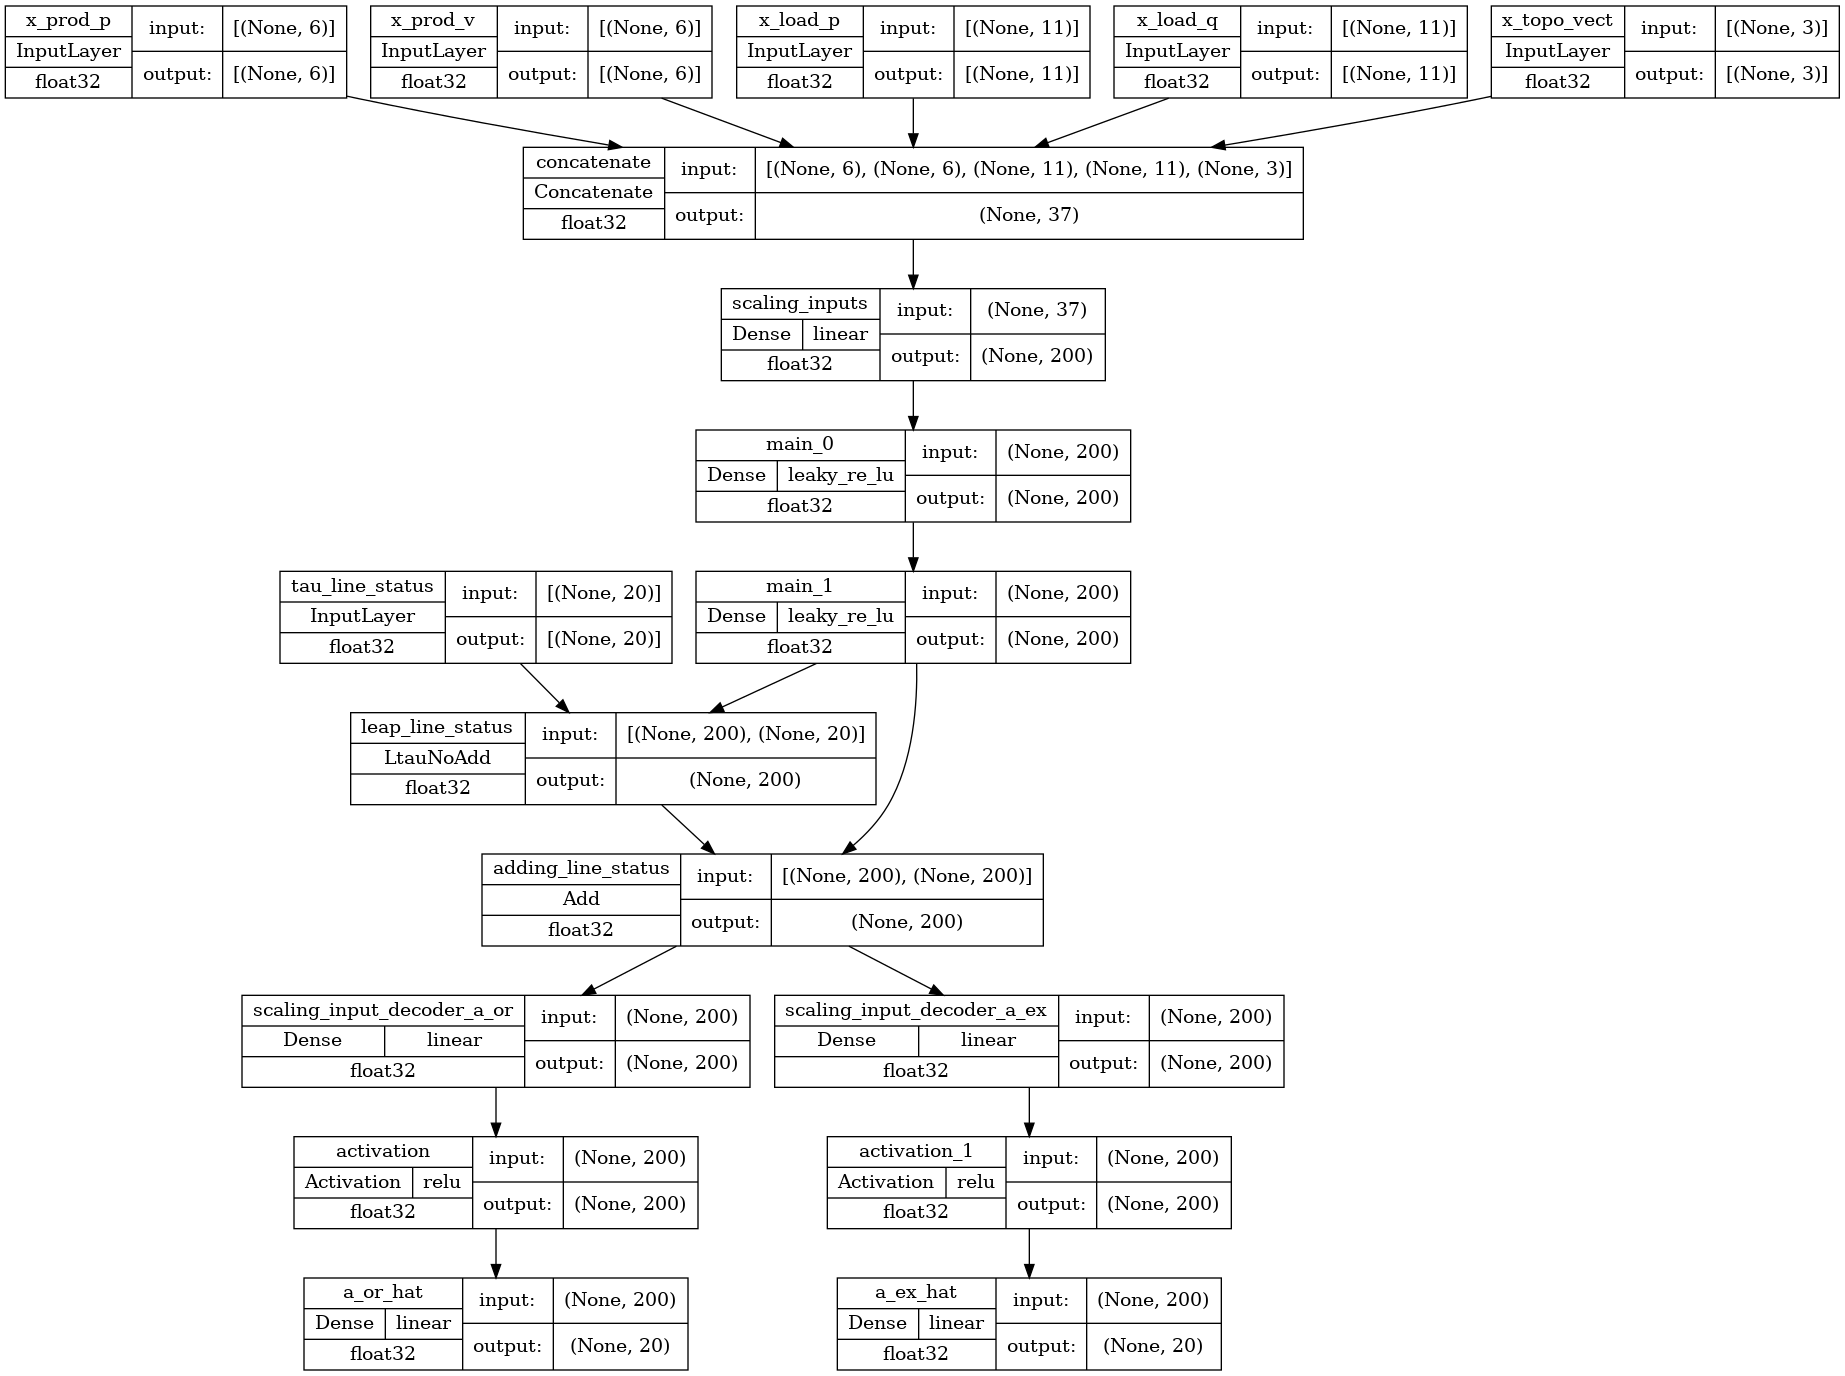

In [9]:
tf.keras.utils.plot_model(
    leap_net1._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [10]:
leap_net1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_prod_p (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 x_prod_v (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 x_load_p (InputLayer)          [(None, 11)]         0           []                               
                                                                                                  
 x_load_q (InputLayer)          [(None, 11)]         0           []                               
                                                                                              

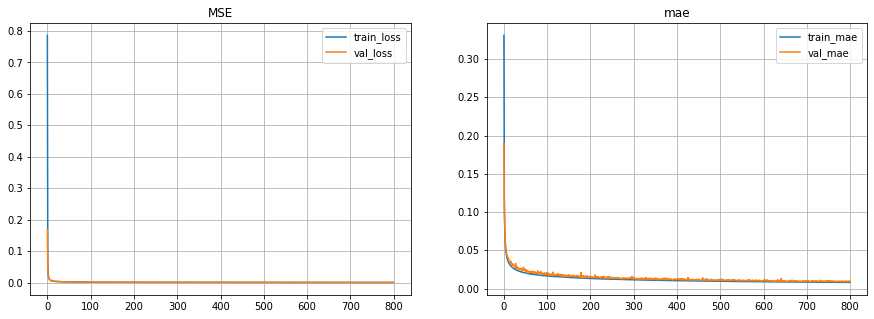

In [11]:
leap_net1.visualize_convergence()

In [12]:
tf_leapnet_metrics1 = benchmark1.evaluate_simulator(augmented_simulator=leap_net1,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

4/4 [==============================] - 0s 3ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


4/4 [==============================] - 0s 3ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


11/11 [==============================] - 0s 3ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
leap_net1.save(SAVE_PATH)

In [14]:
import numpy as np
eval_metrics = tf_leapnet_metrics1

print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", eval_metrics["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))

ML : MAPE90 --> A : mean :0.0026972345519167846, std :2.257382327507931e-05
ML : Inf speed-up : 0.22122633107937872
Rediness : Inf speed-up : 0.23570351500529796
OOD : MAPE90 --> A : mean :0.13378624115772186, std :0.000684655533359696


In [15]:
testset_violoation = [eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

oodset_violoation = [eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))


Physics : test --> CURRENT_POS : mean :0.030901, std :0.0018360000000000008
Physics : ood --> CURRENT_POS : mean :0.028706166666666665, std :0.00043749999999999865


In [17]:
callable(tf.keras.layers.LeakyReLU(alpha=0.01))

True

In [18]:
str(tf.keras.layers.LeakyReLU(alpha=0.01))

'<keras.layers.activation.leaky_relu.LeakyReLU object at 0x7f4b03c9c070>'